In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
os.chdir('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/')


In [26]:
col = pd.read_excel('Data/colonies_master.xlsx')
efw = pd.read_excel('Data/efotw-2022-master-index-data-for-researchers-iso.xlsx', sheet_name='EFW Panel Data 2022 Report')
vdem = pd.read_stata('/Users/jpmvbastos/Library/CloudStorage/OneDrive-TexasTechUniversity/Personal/Projects/Data/V-Dem-CY-Core_STATA_v13/V-Dem-CY-Core-v13.dta')
hiel = pd.read_excel('Data/HIEL_Countries_1850-2020-1-1.xlsx', sheet_name='HIEL2')
pop = pd.read_csv('Data/population.csv')

In [27]:
vdem = vdem[['country_name', 'year', 'v2x_polyarchy', 'v2x_libdem', 'v2x_rule', 'v2x_jucon', 'v2xlg_legcon', 'v2xcl_prpty']]
vdem.rename(columns={'country_name': 'country'}, inplace=True)
vdem.replace({'country': {'United Kingdom': 'Britain'}}, inplace=True)

In [29]:
hiel.rename(columns={'U.K.':'Britain'}, inplace=True)
hiel.head()

,year,Australia,New Zealand,Canada,U.S.A.,Japan,Austria,Belgium,Denmark,Finland,...,Greece,Ireland,Italy,Netherlands,Norway,Portugal,Spain,Sweden,Switzerland,Britain
0,1850,7.370177,NaN,7.510861,6.806213,4.606102,6.940374,8.111263,7.970161,NaN,...,6.472487,NaN,NaN,7.992799,7.207302,5.397483,6.114667,7.343413,6.848098,7.631775
1,1851,7.143438,NaN,7.386000,6.799585,3.841691,6.539103,8.058305,8.000717,7.062032,...,6.303446,NaN,NaN,7.840754,7.272691,5.880018,6.232026,7.439410,6.986405,7.733517
2,1852,6.997849,NaN,7.531888,6.867981,4.330228,6.938061,8.015771,8.030629,6.808692,...,5.127223,NaN,NaN,7.657086,7.123638,6.174890,6.368788,7.437745,6.848573,7.704020
3,1853,6.852954,NaN,7.461409,6.867322,3.579719,6.746011,8.011368,8.223173,6.917066,...,5.669832,NaN,NaN,7.726283,7.171848,5.495964,6.172939,7.416812,6.848131,7.582564
4,1854,6.263343,NaN,6.385176,6.632412,5.120513,6.242913,7.276063,8.195692,6.342725,...,6.066569,NaN,NaN,7.678123,6.948659,5.672494,6.232311,7.272991,7.241317,7.482494


In [30]:
#Keep only colonies 
col = col.loc[col['time_total'] > 0]

In [31]:
# Initialize columns with placeholder NaN
for colonizer in col['main'].unique(): 
    col[f'efw_{colonizer.lower()}'] = np.nan
    col[f'timec_{colonizer.lower()}'] = np.nan

In [32]:
# Initialize column
col[['efw_colonizer','timec_total','indep_from','hiel_indep','first_hiel','first_hiel_year','first_hiel_colonizer']] = np.nan

for country in col.loc[col['independence'] >= 1850, 'country']:
    for colonizer in col['main'].unique(): 
        begin_year = col.loc[col['country']==country, f'colstart_{colonizer.lower()}'].values[0]
        end_year = col.loc[col['country']==country, f'colend_{colonizer.lower()}'].values[0]
        if begin_year < 1850 and end_year < 1850:
            continue 
        elif begin_year < 1850 and end_year >= 1850:
            begin_year = 1850
            # First available HIEL will be 1850 for countries colonized pre-1850
            first_hiel = hiel.loc[hiel['year'] == begin_year, colonizer].mean()
            col.loc[col['country'] == country, 'first_hiel'] = first_hiel
            col.loc[col['country'] == country, 'first_hiel_year'] = begin_year
            col.loc[col['country'] == country, 'first_hiel_colonizer'] = colonizer
        elif begin_year > 1850:
            # If this is the first iteration of the loop, save 
            if pd.isna(col.loc[col['country']==country, 'first_hiel']).values[0]:
                first_hiel = hiel.loc[hiel['year'] == begin_year, colonizer].mean()
                col.loc[col['country']==country, 'first_hiel'] = first_hiel
                col.loc[col['country']==country, 'first_hiel_year'] = begin_year
                col.loc[col['country']==country, 'first_hiel_colonizer'] = colonizer
            #If a further subsequent iteration (next colonizer) has an earlier start date, update:
            elif begin_year < col.loc[col['country']==country, 'first_hiel_year'].values[0]:
                first_hiel = hiel.loc[hiel['year'] == begin_year, colonizer].mean() 
                col.loc[col['country']==country, 'first_hiel'] = first_hiel
                col.loc[col['country']==country, 'first_hiel_year'] = begin_year
                col.loc[col['country']==country, 'first_hiel_colonizer'] = colonizer
        else: 
            pass
        if end_year == col.loc[col['country']==country, 'independence'].values[0]:
            col.loc[col['country']==country, 'indep_from'] = colonizer
            # Gets the HIEL of the colonizer at the time of independence
            hiel_indep = hiel.loc[hiel['year'] == end_year, colonizer].mean() 
            col.loc[col['country']==country, 'hiel_indep'] = hiel_indep 
        else:
            pass
        avg_efw = hiel.loc[(hiel['year'] >= begin_year) & (hiel['year'] <= end_year), colonizer].mean() 
        avg_polyarchy = vdem.loc[(vdem['year'] >= begin_year) & (vdem['year'] <= end_year) & (vdem['country'] == colonizer), 'v2x_polyarchy'].mean()
        avg_libdem = vdem.loc[(vdem['year'] >= begin_year) & (vdem['year'] <= end_year) & (vdem['country'] == colonizer), 'v2x_libdem'].mean()
        avg_rule = vdem.loc[(vdem['year'] >= begin_year) & (vdem['year'] <= end_year) & (vdem['country'] == colonizer), 'v2x_rule'].mean()
        avg_jucon = vdem.loc[(vdem['year'] >= begin_year) & (vdem['year'] <= end_year) & (vdem['country'] == colonizer), 'v2x_jucon'].mean()
        avg_legcon = vdem.loc[(vdem['year'] >= begin_year) & (vdem['year'] <= end_year) & (vdem['country'] == colonizer), 'v2xlg_legcon'].mean()
        avg_prpty = vdem.loc[(vdem['year'] >= begin_year) & (vdem['year'] <= end_year) & (vdem['country'] == colonizer), 'v2xcl_prpty'].mean()

        timec = end_year - begin_year + 1
        # Get the average value of these variables for the colonizer 
        for var in ['efw', 'polyarchy', 'libdem', 'rule', 'jucon', 'legcon', 'prpty']:
            col.loc[col['country']==country, f'{var}_{colonizer.lower()}'] = locals()[f'avg_{var}'] * timec
        col.loc[col['country']==country, f'timec_{colonizer.lower()}'] = timec

col['timec_total'] = col[['timec_belgium', 'timec_britain', 'timec_france', 'timec_germany', 'timec_italy',
       'timec_netherlands', 'timec_portugal', 'timec_spain']].sum(axis=1) 

# Get the time-weighted average of the variables for all colonizers
for var in ['efw', 'polyarchy', 'libdem', 'rule', 'jucon', 'legcon', 'prpty']:
    col[f'{var}_colonizer'] = col[[f'{var}_belgium', f'{var}_britain', f'{var}_france', f'{var}_germany', f'{var}_italy',
       f'{var}_netherlands', f'{var}_portugal', f'{var}_spain']].sum(axis=1) / col['timec_total']
    col[f'{var}_colonizer'] = col[f'{var}_colonizer'].replace([np.inf, -np.inf], np.nan)

col = col.drop(columns={'timec_belgium', 'timec_britain', 'timec_france', 'timec_germany',
                         'timec_italy','timec_netherlands', 'timec_portugal', 'timec_spain'})

In [33]:
col[['hiel_indep','main_indep']] = np.nan 

for country in col.loc[col['independence'] >= 1850, 'country']:
    # Get main colonizer, the colonizer at independence, and year of independence
    main = col.loc[col['country'] == country, 'main'].values[0]
    year = col.loc[col['country'] == country, 'independence'].values[0]
    indep_from = col.loc[col['country'] == country, 'indep_from'].values[0]
    # Get HIEL at independence 
    hiel_indep = hiel.loc[(hiel['year'] == year), indep_from].mean()
    col.loc[col['country'] == country, 'hiel_indep'] = hiel_indep
    if main == indep_from: # Cases where main is the one at independence
        col.loc[col['country'] == country, 'main_indep'] = 1
    else: 
        col.loc[col['country'] == country, 'main_indep'] = 0

In [34]:
#Exclude 2020 because of the pandemic
efw = efw.loc[(efw['Year']<2020) & (efw['Year'] >1999)].rename(columns={'World Bank Region': "wb_region"})
efw.sort_values(by=['Countries','Year']).head()

,Year,ISO_Code_2,wb_region,Countries,ISO_Code_3,efw,Area 1,Area 2,Area 3,Area 4,Area 5,std
3300,2000,AL,Europe & Central Asia,Albania,ALB,6.327515,7.553226,4.710276,6.913330,5.701556,6.635993,1.111863
3135,2001,AL,Europe & Central Asia,Albania,ALB,6.472199,7.627792,4.835400,6.799314,5.871650,7.100014,1.103756
2970,2002,AL,Europe & Central Asia,Albania,ALB,6.742276,8.223671,4.845155,7.101343,6.097055,7.291095,1.287959
2805,2003,AL,Europe & Central Asia,Albania,ALB,7.205265,8.204830,5.016305,9.725652,6.107061,6.866163,1.834517
2640,2004,AL,Europe & Central Asia,Albania,ALB,7.128100,7.961247,5.054765,9.558839,6.124404,6.855145,1.730735


In [35]:
means = efw.groupby('ISO_Code_3')[['efw','Area 1','Area 2','Area 3','Area 4','Area 5','std']].mean().rename(columns={'efw':'avg_efw'})
stds = efw.groupby('ISO_Code_3')[['efw','Area 1','Area 2','Area 3','Area 4','Area 5','std']].std().rename(columns={'efw':'efw_std'})
last = efw.loc[efw['Year']==2019].rename(columns={'efw':'efw_2019'})

In [36]:
df = pd.merge(col, means, left_on='country_code', right_on='ISO_Code_3', how='left')
df = pd.merge(df, stds, left_on='country_code', right_on='ISO_Code_3', how='left', suffixes=('',"_std"))
df = pd.merge(df, last, left_on='country_code', right_on='ISO_Code_3', how='left', suffixes=('',"_2019"))

In [37]:
# Reload because we have dropped years < 2000 for the average above
efw = pd.read_excel('Data/efotw-2022-master-index-data-for-researchers-iso.xlsx', sheet_name='EFW Panel Data 2022 Report')
efw.rename(columns={'ISO_Code_3':'Code'}, inplace=True)

In [38]:
# Initialize columns
df[['efw_indep_year', 'efw_indep', 'efw_indep2_year', 'efw_indep2',
       'efw_indep3_year', 'efw_indep3','efw_indep4_year', 'efw_indep4', 'efw_indep5_year', 'efw_indep5']] = np.nan

for country in df['country_code'].sort_values():
    year = df.loc[df['country_code']==country, 'independence'].values[0] #Extracts independence year
    print(f'Evaluating: {country}, independence {year}.')
    for gap in [10,20,30,40,50]:
        min_range = year + gap - 10
        max_range = year + gap - 1
        if min_range < 1940 or min_range > 2019:
            print(f'No EFW data for the decade {min_range}-{max_range}. Proceeding to next decade.')
        elif country in efw['Code'].unique() and min_range<2019:
            print(f'Evaluating decade {min_range}-{max_range}.')
            efw_year = efw.loc[(efw['Code']==country) & (efw['efw'].notnull()) & (efw['Year']>= min_range), 'Year'].values.min() #Earliest available year for EFW
            print(f'Country in data, earliest EFW from {efw_year}') 
            if efw_year in range(min_range, max_range):
                diff = efw_year - year
                if diff < 10: # First decade following independence 
                    print(f'1st decade until {max_range}. Saving EFW from {efw_year} as 1st decade.')
                    df.loc[df['country_code']==country, 'efw_indep_year'] = efw_year
                    efw_indep = efw.loc[(efw['Code'] == country) & (efw['Year'] == efw_year), 'efw'].values[0]
                    df.loc[df['country_code']==country, 'efw_indep']  = efw_indep
                elif diff >= 10 and diff <20:  # Second decade following independence
                    print(f'2nd decade until {year+gap-1}. Saving EFW from {efw_year} as 2nd decade.')
                    df.loc[df['country_code']==country, 'efw_indep2_year'] = efw_year
                    efw_indep = efw.loc[(efw['Code'] == country) & (efw['Year'] == efw_year), 'efw'].values[0]
                    df.loc[df['country_code']==country, 'efw_indep2']  = efw_indep 
                elif diff>=20 and diff<30:  # Third decade following independence
                    print(f'3rd decade until {year+gap-1}. Saving EFW from {efw_year} as 3rd decade.')
                    df.loc[df['country_code']==country, 'efw_indep3_year'] = efw_year
                    efw_indep = efw.loc[(efw['Code'] == country) & (efw['Year'] == efw_year), 'efw'].values[0]
                    df.loc[df['country_code']==country, 'efw_indep3']  = efw_indep 
                elif diff>=30 and diff<40:  # Fourth decade following independence
                    print(f'4th decade until {year+gap-1}. Saving EFW from {efw_year} as 4th decade.')
                    df.loc[df['country_code']==country, 'efw_indep4_year'] = efw_year
                    efw_indep = efw.loc[(efw['Code'] == country) & (efw['Year'] == efw_year), 'efw'].values[0]
                    df.loc[df['country_code']==country, 'efw_indep4']  = efw_indep 
                elif diff>=40 and diff<50:  # Fifth decade following independence
                    print(f'5th decade until {year+gap-1}. Saving EFW from {efw_year} as 5th decade.')
                    df.loc[df['country_code']==country, 'efw_indep5_year'] = efw_year
                    efw_indep = efw.loc[(efw['Code'] == country) & (efw['Year'] == efw_year), 'efw'].values[0]
                    df.loc[df['country_code']==country, 'efw_indep5']  = efw_indep 
                else: 
                    print(f'Difference is {diff}, does not fit the criteria')
            else: 
                print('No EFW data for this decade, checking next decade')
        else: # For countries meeting data availability
            print(f'No available data for {country}, resuming loop') 
        # EFW_YEAR gives the first available EFW within decade D following independence 
        # For instance, if indep==1960, efw_year in decade 2 will be 1970, and so it will extract the first available EFW within
        # 1970 and 1980

            

Evaluating: AGO, independence 1974.
Evaluating decade 1974-1983.
Country in data, earliest EFW from 2005
No EFW data for this decade, checking next decade
Evaluating decade 1984-1993.
Country in data, earliest EFW from 2005
No EFW data for this decade, checking next decade
Evaluating decade 1994-2003.
Country in data, earliest EFW from 2005
No EFW data for this decade, checking next decade
Evaluating decade 2004-2013.
Country in data, earliest EFW from 2005
4th decade until 2013. Saving EFW from 2005 as 4th decade.
Evaluating decade 2014-2023.
Country in data, earliest EFW from 2014
5th decade until 2023. Saving EFW from 2014 as 5th decade.
Evaluating: ARE, independence 1971.
Evaluating decade 1971-1980.
Country in data, earliest EFW from 1975
1st decade until 1980. Saving EFW from 1975 as 1st decade.
Evaluating decade 1981-1990.
Country in data, earliest EFW from 1985
2nd decade until 1990. Saving EFW from 1985 as 2nd decade.
Evaluating decade 1991-2000.
Country in data, earliest EFW 

In [39]:
df.sort_values('country_code')

,country,country_code,col_belgium,col_britain,col_france,col_germany,col_italy,col_netherlands,col_portugal,col_spain,...,efw_indep_year,efw_indep,efw_indep2_year,efw_indep2,efw_indep3_year,efw_indep3,efw_indep4_year,efw_indep4,efw_indep5_year,efw_indep5
1,Angola,AGO,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2005.0,4.214590,2014.0,5.071419
119,United Arab Emirates,ARE,0,1,0,0,0,0,0,0,...,1975.0,6.300634,1985.0,6.447161,1995.0,7.011978,2001.0,6.962194,2011.0,7.310054
3,Argentina,ARG,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Antigua and Barbuda,ATG,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,AUS,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,6.473794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Samoa,WSM,0,1,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,Yemen,YEM,0,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.0,6.297041
101,South Africa,ZAF,0,1,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,4.433364,1955.0,4.924351
126,Zambia,ZMB,0,1,0,0,0,0,0,0,...,1965.0,4.802119,1975.0,4.246023,1985.0,3.820589,1995.0,4.634192,2004.0,6.802513


In [40]:
pop = pop.rename(columns={'Code':'country_code',
                          'Population (historical)':'pop',
                          'Year':'year'})

In [41]:
df = df.merge(pop, left_on=['country_code','independence'], right_on=['country_code','year'], how='left')

## Merge Data

In [42]:
## 
rug = pd.read_csv('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Data/terrain-ruggedness-index.csv')
qog = pd.read_excel('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Data/Quality_of_Govt.xls', sheet_name='data')
euro = pd.read_excel('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Data/euro_share.xlsx', sheet_name='data')
coord = pd.read_csv('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Data/country-coord.csv')

In [43]:
rug = rug.rename(columns={'Code':'country_code','Terrain Ruggedness Index 100m (Nunn and Puga 2012)':'ruggedness'})
rug = rug[['country_code','ruggedness']]
qog = qog.rename(columns={'flopcode':'country_code','avelf':'avg_ethnofrac'})
qog['country_code'] = qog['country_code'].str.upper() 
qog = qog[['country_code','legor_uk','legor_fr','legor_so','legor_ge','legor_sc','avg_ethnofrac']]
coord.columns = ['country_code','lat','lon']


In [44]:
display(rug,qog,euro,coord)

,country_code,ruggedness
0,AFG,251.8
1,ALB,342.7
2,DZA,51.0
3,ASM,264.7
4,AND,571.7
...,...,...
229,WLF,130.6
230,ESH,20.3
231,YEM,232.3
232,ZMB,53.3


,country_code,legor_uk,legor_fr,legor_so,legor_ge,legor_sc,avg_ethnofrac
0,IRQ,0.0,1.0,0.0,0.0,0.0,NaN
1,LAO,0.0,0.0,1.0,0.0,0.0,0.250000
2,SOM,1.0,0.0,0.0,0.0,0.0,0.079116
3,PRK,0.0,0.0,1.0,0.0,0.0,NaN
4,HTI,0.0,1.0,0.0,0.0,0.0,0.064405
...,...,...,...,...,...,...,...
265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,BTN,1.0,0.0,0.0,0.0,0.0,0.437500


,country_code,euro_share
0,DZA,0.105
1,AGO,0.002
2,ATG,0.195
3,ARG,0.147
4,AUS,0.620
...,...,...
64,UGA,0.001
65,USA,0.807
66,VEN,0.081
67,ZMB,0.027


,country_code,lat,lon
0,AFG,33.0000,65.0
1,ALB,41.0000,20.0
2,DZA,28.0000,3.0
3,ASM,-14.3333,-170.0
4,AND,42.5000,1.6
...,...,...,...
239,WLF,-13.3000,-176.2
240,ESH,24.5000,-13.0
241,YEM,15.0000,48.0
242,ZMB,-15.0000,30.0


In [45]:
df = df.merge(rug, on='country_code', how='left')
df = df.merge(qog, on='country_code', how='left')
df = df.merge(euro, on='country_code', how='left')
df = df.merge(coord, on='country_code', how='left')

In [46]:
df.to_excel('Data/colonies.xlsx', index=False)

# Panel

In [35]:
efw = efw.rename(columns={'Countries':'country',
                          'Code':'country_code',
                          'World Bank Region':'wb_region',
                          'Year':'year'})
df = df.drop(columns={'year'})
data = efw[['year','country_code','efw']].merge(df, on='country_code', how='left')

In [36]:
data

,year,country_code,efw,country,col_belgium,col_britain,col_france,col_germany,col_italy,col_netherlands,...,ruggedness,legor_uk,legor_fr,legor_so,legor_ge,legor_sc,avg_ethnofrac,euro_share,lat,lon
0,2020,ALB,7.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,DZA,5.120000,Algeria,0.0,0.0,1.0,0.0,0.0,0.0,...,51.0,0.0,1.0,0.0,0.0,0.0,0.293724,0.105,28.0,3.0
2,2020,AGO,5.910000,Angola,0.0,0.0,0.0,0.0,0.0,0.0,...,85.8,0.0,1.0,0.0,0.0,0.0,0.772755,0.002,-12.5,18.5
3,2020,ARG,4.870000,Argentina,0.0,0.0,0.0,0.0,0.0,0.0,...,77.5,0.0,1.0,0.0,0.0,0.0,0.176932,0.147,-34.0,-64.0
4,2020,ARM,7.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908,1950,URY,5.927550,Uruguay,0.0,0.0,0.0,0.0,0.0,0.0,...,43.5,0.0,1.0,0.0,0.0,0.0,0.066667,NaN,-33.0,-56.0
4909,1950,VEN,6.304037,Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,...,63.4,0.0,1.0,0.0,0.0,0.0,0.052500,0.081,8.0,-66.0
4910,1950,YEM,5.628150,Yemen,0.0,1.0,0.0,0.0,0.0,0.0,...,232.3,0.0,1.0,0.0,0.0,0.0,0.012200,NaN,15.0,48.0
4911,1950,ZMB,4.069384,Zambia,0.0,1.0,0.0,0.0,0.0,0.0,...,53.3,1.0,0.0,0.0,0.0,0.0,0.829398,0.027,-15.0,30.0


In [341]:
data.groupby('year')['efw'].mean()

year
1950    4.958831
1955    5.039866
1960    5.382645
1965    5.421125
1970    5.699777
1975    5.330897
1980    5.358043
1985    5.423119
1990    5.716292
1995    6.163039
2000    6.592760
2001    6.599041
2002    6.663490
2003    6.681009
2004    6.710922
2005    6.736056
2006    6.780060
2007    6.810935
2008    6.769782
2009    6.774924
2010    6.809513
2011    6.812160
2012    6.823437
2013    6.820710
2014    6.869996
2015    6.868486
2016    6.872591
2017    6.840911
2018    6.888338
2019    6.893302
2020    6.749758
Name: efw, dtype: float64

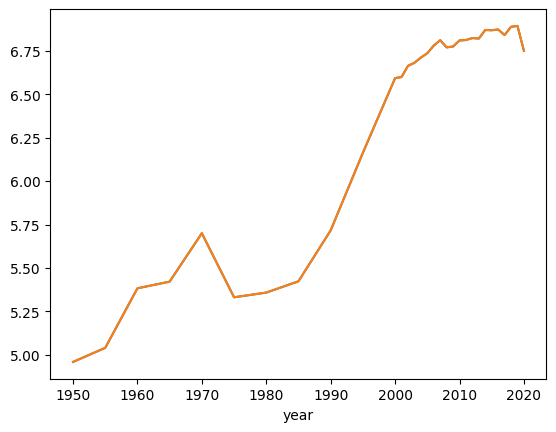

In [340]:
data.groupby('year')['efw'].mean().plot()

plt.show()

In [37]:
data.to_excel('Data/colonies-panel.xlsx', index=False)

# Map

In [206]:
colonies = pd.read_stata('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Data/ColonialEFW.dta')

In [215]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from shapely.geometry import LineString

# Load world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the colonial data
map = world.merge(colonies, how='left', left_on='iso_a3', right_on='country_code').copy()

# dummy for colonizer
map['is_colonizer'] = np.where(map['iso_a3'].isin(['GBR','ITA','ESP','GER','NLD','PRT','FRA','BEL']), 1, 0)

/var/folders/xd/gksdz50d7r3765bw8t_98y880000gn/T/ipykernel_45954/435339571.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [229]:
map['colonizer'].unique()

['Britain', 'Germany', NaN, 'Netherlands', 'Spain', 'Belgium', 'France', 'Portugal', 'Italy']
Categories (8, object): ['Belgium' < 'Britain' < 'France' < 'Germany' < 'Italy' < 'Netherlands' < 'Portugal' < 'Spain']

In [233]:
# List colonizers
colonizers = ['Britain', 'Germany','Netherlands', 'Spain', 'Belgium', 'France', 'Portugal', 'Italy']

colonizer_dict = {
    'GBR': 'Britain',
    'ITA': 'Italy',
    'ESP': 'Spain',
    'GER': 'Germany',
    'NLD': 'Netherlands',
    'PRT': 'Portugal',
    'FRA': 'France',
    'BEL': 'Belgium'
}

# Place my name converntion in the main for the colonizers
map.loc[map['is_colonizer'] == 1, 'colonizer'] = map['iso_a3'].map(colonizer_dict)

# Merge the avg. HIEL value for the colonizer (I'm placing in avg_efw column to facilitate code later)
for colonizer in colonizers:
    min_year = colonies.loc[colonies['colonizer']==colonizer, f'colstart_{colonizer.lower()}'].min()
    max_year = colonies.loc[colonies['colonizer']==colonizer, 'year_independence'].max()
    print(f'{colonizer} had colonies between {min_year} and {max_year}')
    avg_hiel =  hiel.loc[(hiel['year'] >= min_year) & (hiel['year'] <= max_year), colonizer].mean() 
    if min_year > 1850: 
        print(f'Avg. HIEL for {colonizer} between {min_year} and {max_year} is {avg_hiel}')
    else:
        print(f'Avg. HIEL for {colonizer} between 1850 and {max_year} is {avg_hiel}')
    map.loc[(map['is_colonizer'] == 1) & (map['colonizer']==colonizer), 'avg_efw'] = avg_hiel

# Create a colormap for the colonizers
colors = list(mcolors.TABLEAU_COLORS.values())[:len(colonizers)]
colormap = {colonizer: colors[i] for i, colonizer in enumerate(colonizers) if colonizer is not None}

# Assign colors to each country in the dataframe
map['color'] = map['colonizer'].map(colormap)

Britain had colonies between 1607.0 and 1984
Avg. HIEL for Britain between 1850 and 1984 is 7.881598071895483
Germany had colonies between 1884.0 and 1962
Avg. HIEL for Germany between 1884.0 and 1962 is 6.934286502480258
Netherlands had colonies between 1621.0 and 1964
Avg. HIEL for Netherlands between 1850 and 1964 is 7.986710917077177
Spain had colonies between 1514.0 and 1898
Avg. HIEL for Spain between 1850 and 1898 is 6.524811733187058
Belgium had colonies between 1885.0 and 1960
Avg. HIEL for Belgium between 1885.0 and 1960 is 7.470328602057372
France had colonies between 1665.0 and 1977
Avg. HIEL for France between 1850 and 1977 is 7.356760555418112
Portugal had colonies between 1462.0 and 1975
Avg. HIEL for Portugal between 1850 and 1975 is 6.344633665944509
Italy had colonies between 1912.0 and 1952
Avg. HIEL for Italy between 1912.0 and 1952 is 5.936614483228153


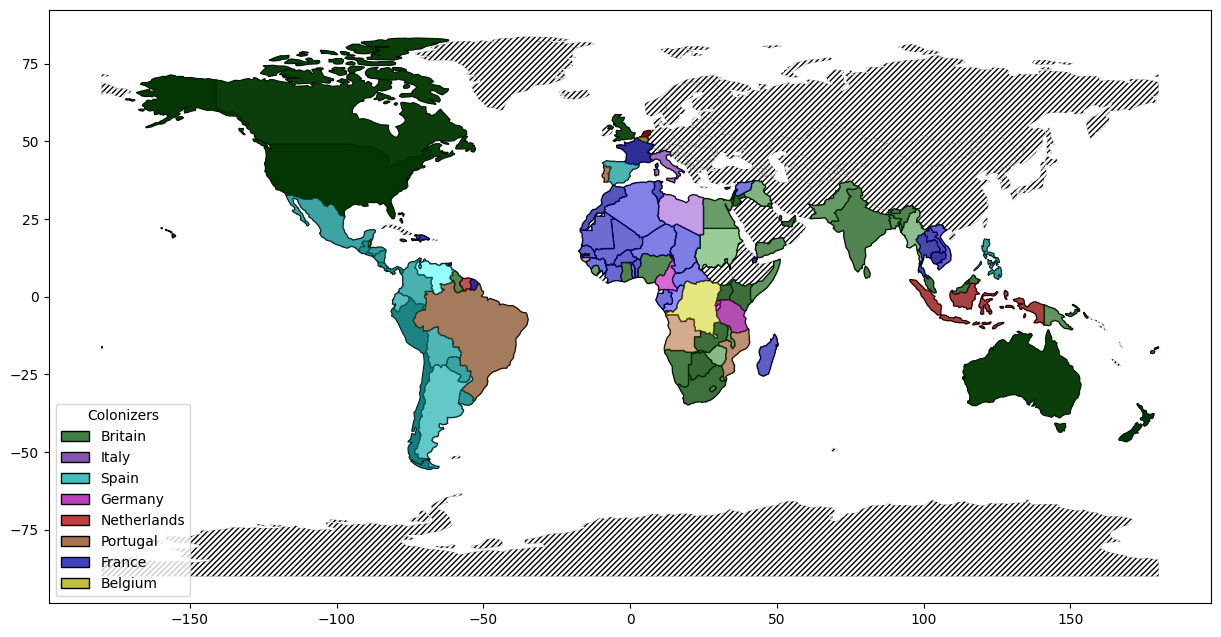

In [302]:
from matplotlib.patches import Patch

# Create a grid of subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 10)) 

# Create the norm for the variable
norm = mcolors.Normalize(vmin=map['avg_efw'].min(), vmax=map['avg_efw'].max())

# Create a colormap for grayscale
grayscale_cmap = plt.cm.Greys

map.loc[map['colonizer'].isnull()].plot(ax=ax, hatch='//////', color='white', linewidth=0.1, edgecolor='black')

# Plot the grayscale map for the avg. EFW of the colonies
map.plot(column='avg_efw', cmap=grayscale_cmap, norm=norm, ax=ax, edgecolor='black', alpha=1.0)

# Define a color map for colonizers
colonizer_colors = {
    'Britain': 'green',
    'Italy': 'blueviolet',
    'Spain': 'cyan',
    'Germany': 'magenta',
    'Netherlands': 'red',
    'Portugal': 'chocolate',
    'France': 'blue',
    'Belgium': 'yellow'
}

# Overlay colonizer colors with transparency
for colonizer, color in colonizer_colors.items():
    #color = map.loc[map['colonizer'] == colonizer, 'color'].values[0]
    map[map['colonizer'] == colonizer].plot(
        ax=ax,
        color=color,
        edgecolor='black',
        linewidth=0.15,
        alpha=0.4  # Transparency
    )

# Define the grey color
grey = np.array([0.5, 0.5, 0.5])  # Light grey in RGB

# Create a list of legend elements with colors mixed with grey
legend_elements = []
for country, color in colonizer_colors.items():
    # Convert the colonizer color to RGB
    color_rgb = np.array(mcolors.to_rgb(color))
    
    # Mix the color with grey by averaging the values (adjust alpha blending)
    mixed_color = 0.5 * color_rgb + 0.5 * grey  # Mix 70% color with 30% grey
    
    # Create a patch with the mixed color
    legend_elements.append(Patch(facecolor=mixed_color, edgecolor='black', label=country))

plt.legend(handles=legend_elements, loc="lower left", ncol=1, frameon=True, title="Colonizers")

plt.savefig('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Results/Plots/colonization_map.png', format='png')

plt.show()

In [305]:
# plt does not allow saving as EPS with transparencies 

from PIL import Image
# Open the PNG image with Pillow
img = Image.open('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Results/Plots/colonization_map.png').convert('RGB')
# Save the image as EPS
img.save('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Results/Plots/colonization_map.eps', format='eps')


# Case Studies

In [336]:
for year in [1873,1895,1910]:
    avg_efw = hiel.loc[(hiel['year'] >= year) & (hiel['year'] < 1961), 'France'].mean()
    print(avg_efw)

7.222194068142515
7.001443545719855
6.715308157774498


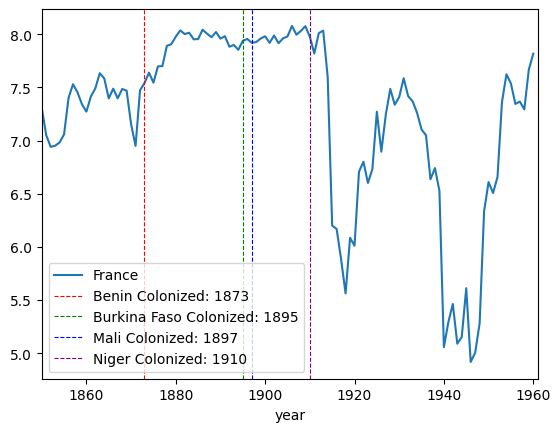

In [334]:
subset = hiel.loc[(hiel['year'] >= 1850) & (hiel['year'] < 1961), ['year','France']]  # Subset the data
subset.plot(x='year', y='France')  # Specify 'year' as the x-axis and 'France' as the y-axis

# Set the x-axis range
plt.xlim(1850, 1961)

# Add vertical lines for specific years
plt.axvline(x=1873, color='red', linestyle='--', linewidth=0.8, label=f'Benin Colonized: 1873')
plt.axvline(x=1895, color='green', linestyle='--', linewidth=0.8, label=f'Burkina Faso Colonized: 1895')
plt.axvline(x=1897, color='blue', linestyle='--', linewidth=0.8, label=f'Mali Colonized: 1897')
plt.axvline(x=1910, color='purple', linestyle='--', linewidth=0.8, label=f'Niger Colonized: 1910')

# Add a legend
plt.legend()

plt.show()


# Weights Plot

In [157]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# Reset Matplotlib parameters to default
mpl.rcParams.update(mpl.rcParamsDefault)

# Load world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load dataset containing variable values for each country
# Replace 'your_data.csv' with your dataset file containing country codes/names and variable values
data = pd.read_excel('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Data/ColonialEFW.xlsx')

/Users/jpmvbastos/Library/Python/3.9/lib/python/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/var/folders/xd/gksdz50d7r3765bw8t_98y880000gn/T/ipykernel_45954/1174419897.py:1: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd
/var/folders/xd/gksdz50d7r3765bw8t_98y880000gn/T/ipykernel_45954/1174419897.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets

In [158]:
data[['relwt3', 'relwt4']].describe()

,relwt3,relwt4
count,87.000000,107.000000
mean,0.011494,0.009346
std,0.002769,0.003626
min,0.005860,0.000590
25%,0.009942,0.006369
50%,0.012360,0.009993
75%,0.013724,0.012274
max,0.017339,0.015619


In [159]:
merged_data = world.merge(data, how='left', left_on='iso_a3', right_on='country_code')

# Create a dummy = 1 if the variable is missing, 0 otherwise
merged_data['miss3'] = np.where(merged_data['relwt3'].isnull(), 1, 0)
merged_data['miss4'] = np.where(merged_data['relwt4'].isnull(), 1, 0)

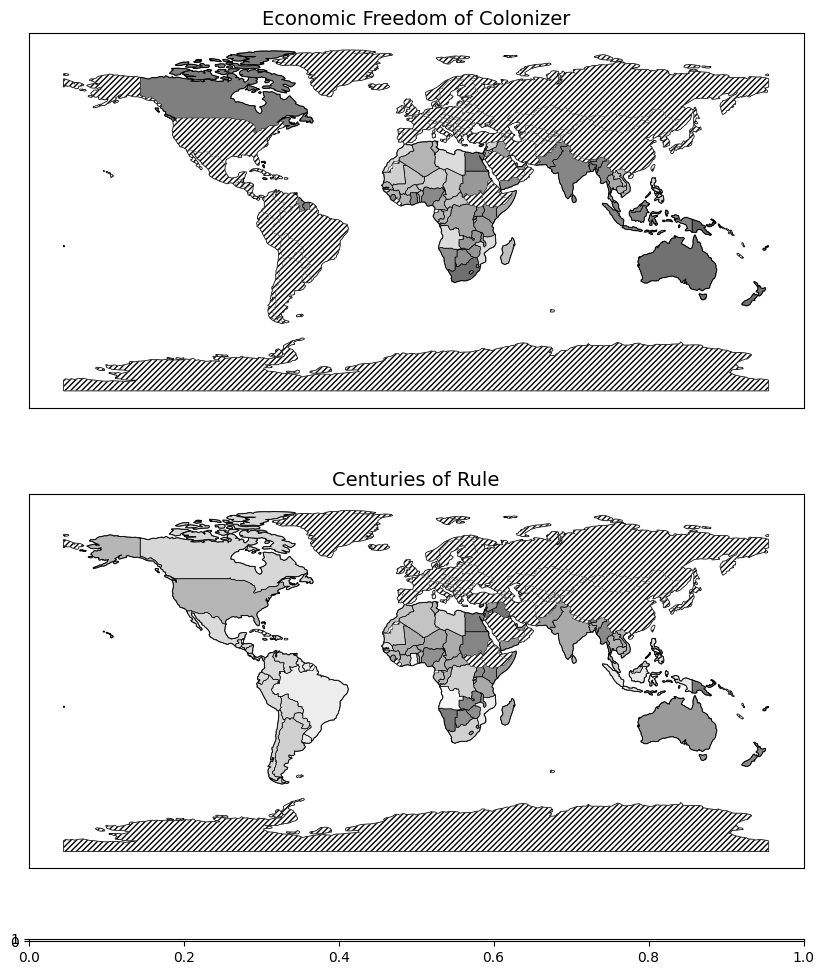

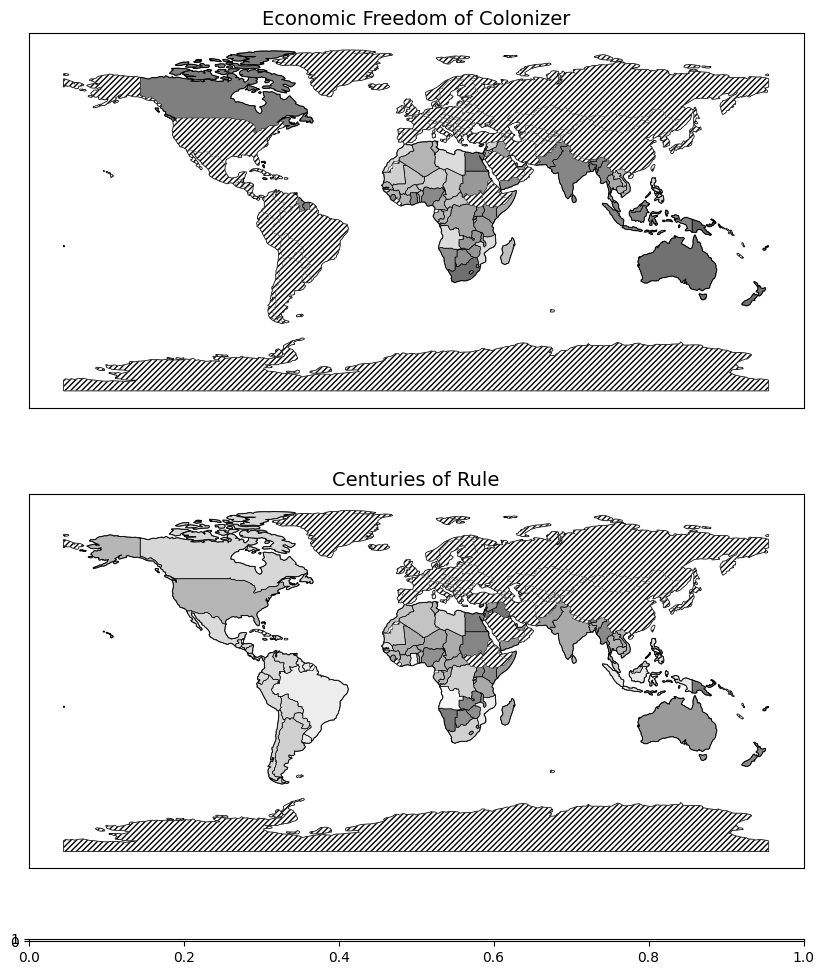

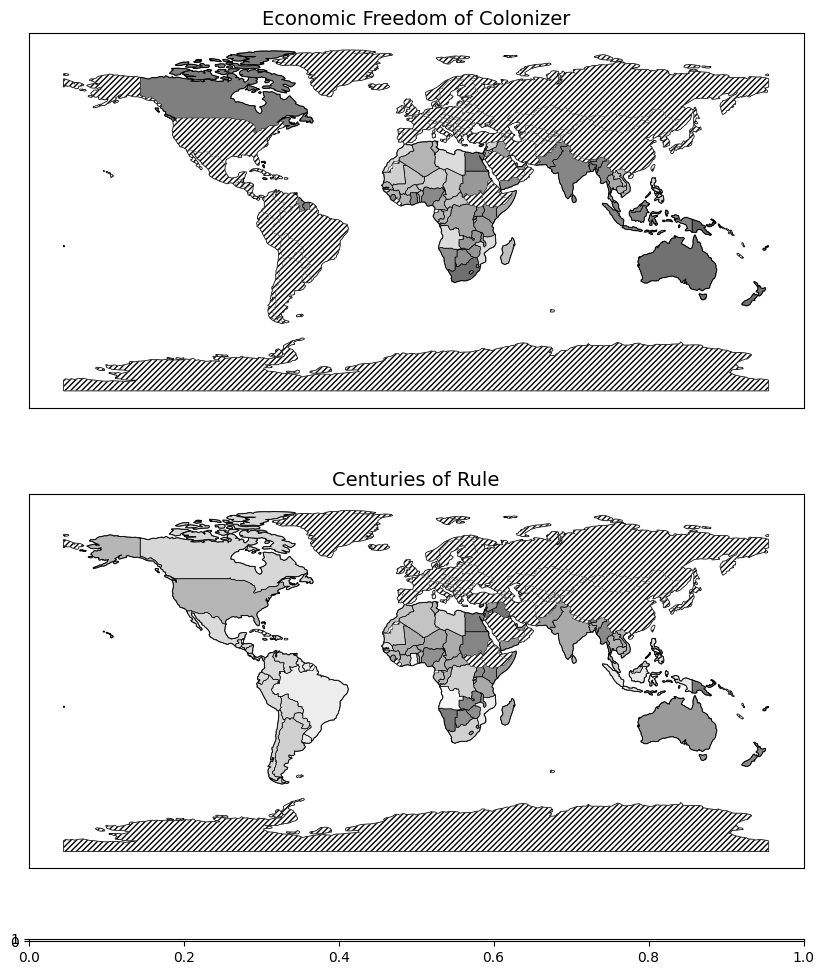

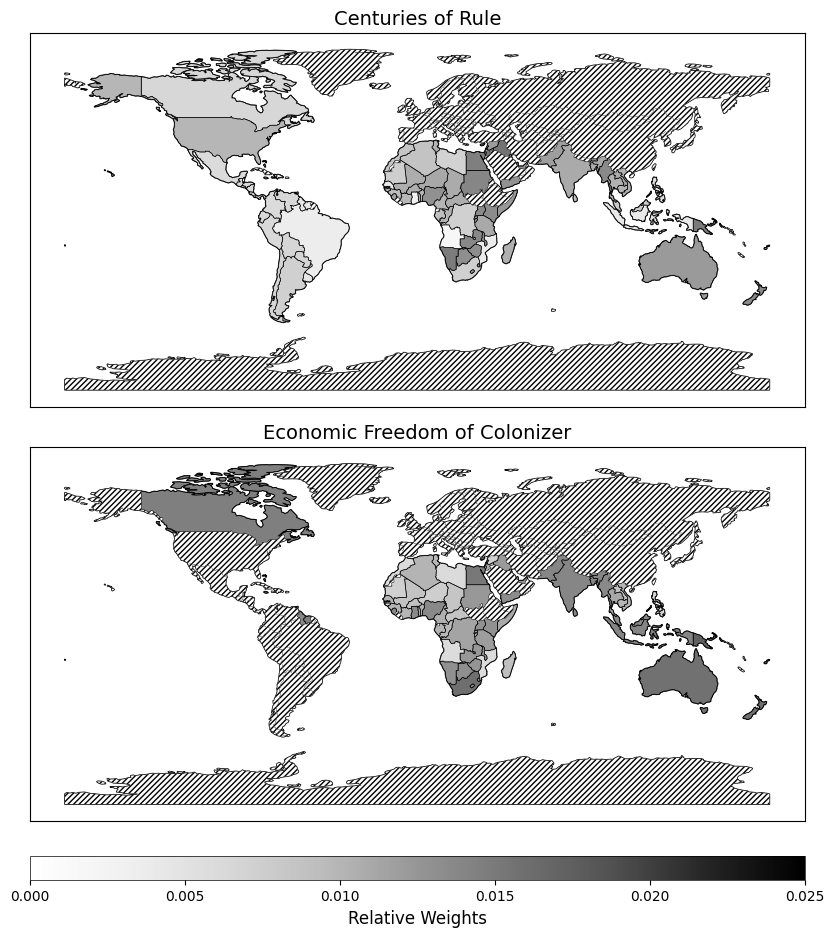

In [163]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a grid of subplots
fig, (ax1, ax2, cax) = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1.5, 1.5, 0.01]}) 

# Plot the first map
world.plot(ax=ax1, color='white', edgecolor='black')
merged_data[merged_data['miss3']==0].plot(column='relwt3', cmap='Greys', linewidth=0.5, ax=ax1, edgecolor='black', legend=False, vmin=0, vmax=0.025)
merged_data[merged_data['miss3']==1].plot(ax=ax1, hatch='//////', color='white', linewidth=0.1, edgecolor='black')
ax1.set_title('Economic Freedom of Colonizer', fontsize=14)
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the second map
world.plot(ax=ax2, color='white', edgecolor='black')
merged_data[merged_data['miss4']==0].plot(column='relwt4', cmap='Greys', linewidth=0.5, ax=ax2, edgecolor='black', legend=False, vmin=0, vmax=0.025)
merged_data[merged_data['miss4']==1].plot(ax=ax2, hatch='//////', color='white', linewidth=0.1, edgecolor='black')
ax2.set_title('Centuries of Rule', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])

# Create a ScalarMappable for the colorbar
norm = Normalize(vmin=0, vmax=0.025)
sm = ScalarMappable(norm=norm, cmap='Greys')

# Add colorbar
divider = make_axes_locatable(cax)
cbar = fig.colorbar(sm, ax=cax, orientation='horizontal', pad=0.05, cax=cax)
cbar.set_label('Relative Weights', fontsize=12)
cbar.outline.set_edgecolor('black')   # Set edge color of the colorbar
cbar.outline.set_linewidth(.5)         # Set linewidth of the colorbar edge

ax1.set_facecolor('white')
ax2.set_facecolor('white')

# Adjust spacing between ax1 and ax2
#plt.subplots_adjust(hspace=-)  # Adjust the vertical space between subplots

# Adjust the top of ax1 and the bottom of ax2 to reduce space between them
ax1.set_position([ax1.get_position().x0, ax1.get_position().y0, ax1.get_position().width, 0.45])
ax2.set_position([ax2.get_position().x0, 0.9, ax2.get_position().width, 0.45])

# Adjust the position of cax to align with the subplots
cax.set_position([cax.get_position().x0, 0.575, cax.get_position().width, 0.02])

plt.show()

# Export as EPS file
fig.savefig('/Users/jpmvbastos/Documents/GitHub/ColonialLegacy/Results/Relative Weights.png', format='png', dpi=500)

